# Tutorial: ACCorDIoN test data

## Load Libraries

In [1]:
from accordion import pdac
from accordion.Accordion import Accordion 
import seaborn as sns
import skimpy as skm

#### 1. Loading data and metadata

In [33]:
data = pdac.load_peng2019()
pdata_metadata['label1'] = ['Normal Pancreas' if i.find('normal')> 0 else 'PDAC' for i in pdata_metadata.accLabel]

#### 2. This are tables made by CrossTalkeR/Liana therefore we need to filter it to keep only the single(per sample) networks

In [34]:
data = {i:data[i] for i in data.keys()  if i.find("_x_") < 0 }

#### 3. Now with the tables from CrossTalkeR/Liana we build the Accordion Object 

In [32]:
AaccPDAC = Accordion(tbls=data,weight='lr_means')

#### 4. Computing a PCA using the edge distribuition per sample

In [5]:
AaccPDAC.make_pca()

#### 5. Normalizing the data $\mathcal{P}$

In [6]:
for i in AaccPDAC.p.columns:
    AaccPDAC.p[i] = AaccPDAC.p[i]/AaccPDAC.p[i].sum()

In [2]:
sns.heatmap(AaccPDAC.p)

NameError: name 'sns' is not defined

#### 6. Building the Cost Matrix

In [7]:
AaccPDAC.compute_cost_all()

CTD


/home/james/.local/lib/python3.10/site-packages/accordion/distances.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G,weight=weight).todense()


('distance', 'correlation')
glasso


/home/james/.local/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [8]:
AaccPDAC.compute_wassestein(cost='correlation')

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 52.95it/s]


In [9]:
AaccPDAC.compute_wassestein(cost='CTD')

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 62.04it/s]


In [10]:
from sklearn.cluster import KMeans

In [11]:
clsm = KMeans(n_clusters=2)

In [12]:
import pydiffmap as dm

In [13]:
aux = dm.diffusion_map.DiffusionMap.from_sklearn(metric='precomputed',n_evecs = 3, epsilon =1, alpha = 0.5, k=64)
aux = aux.fit_transform(AaccPDAC.wdist['CTD'])

<AxesSubplot: >

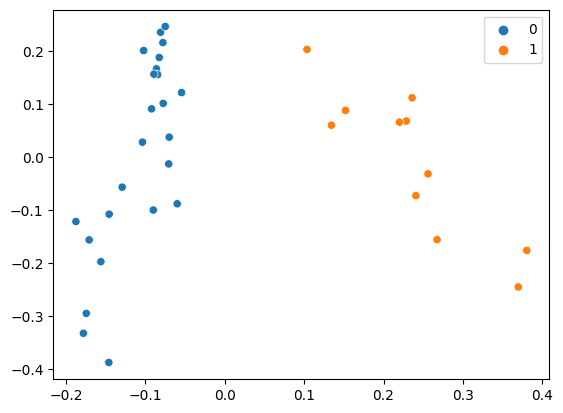

In [14]:
sns.scatterplot(x=aux[:,0],y=aux[:,1],hue=clsm.fit_predict(AaccPDAC.wdist['CTD'])) 

In [15]:
mtemp = AaccPDAC.Cs['CTD'].copy()

<AxesSubplot: ylabel='Density'>

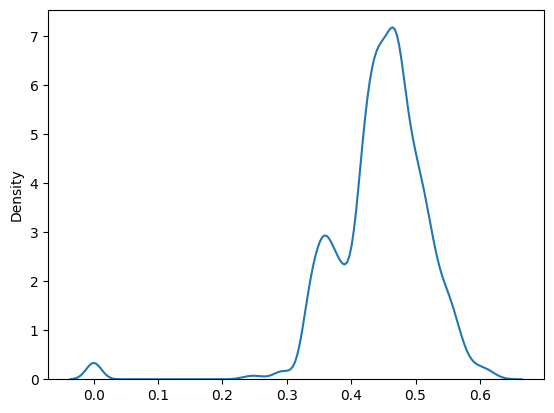

In [16]:
sns.kdeplot(mtemp.ravel())

In [17]:
import numpy as np

In [18]:
mtemp[mtemp>np.quantile(mtemp.ravel(), q=0.8)] = max(mtemp.ravel())

<AxesSubplot: ylabel='Density'>

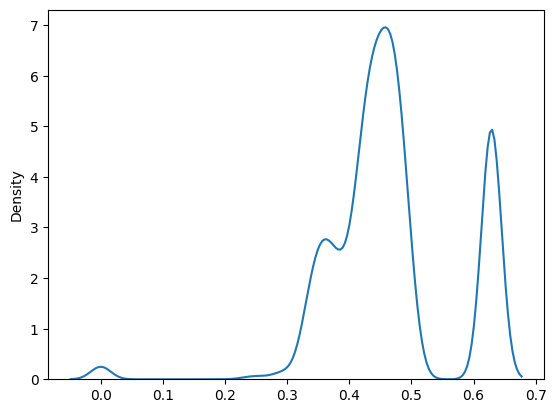

In [19]:
sns.kdeplot(mtemp.ravel())

In [20]:
AaccPDAC.Cs['PrunneCTD'] = mtemp

In [21]:
AaccPDAC.compute_wassestein(cost='PrunneCTD')

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 57.86it/s]


In [22]:
aux = dm.diffusion_map.DiffusionMap.from_sklearn(metric='precomputed',n_evecs = 3, epsilon =1, alpha = 0.5, k=64)
aux = aux.fit_transform(AaccPDAC.wdist['PrunneCTD'])

<AxesSubplot: >

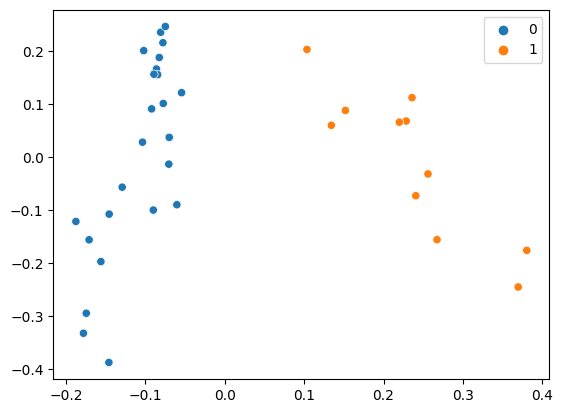

In [23]:
sns.scatterplot(x=aux[:,0],y=aux[:,1],hue=clsm.fit_predict(AaccPDAC.wdist['PrunneCTD'])) 

In [29]:
aux = dm.diffusion_map.DiffusionMap.from_sklearn(metric='precomputed',n_evecs = 3, epsilon =1, alpha = 0.5, k=64)
aux = aux.fit_transform(AaccPDAC.wdist['cosine'])

<AxesSubplot: >

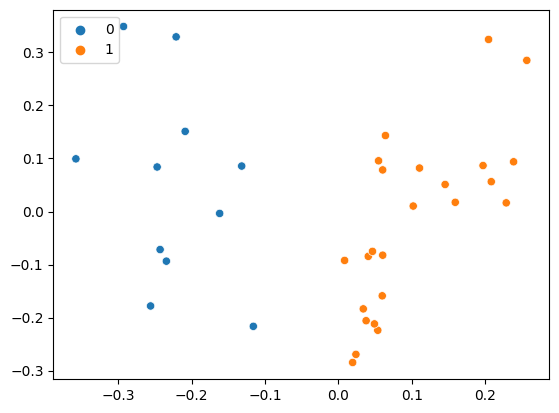

In [30]:
sns.scatterplot(x=aux[:,0],y=aux[:,1],
                hue=pdata_metadata.loc[AaccPDAC.p.columns,'label1'].astype('category').cat.codes) 